![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 11 - RNN </center>
### <center> Advanced RNN - Solution </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/11_RNN/MainAdvancedRNN_Solution.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt

import torch
import torch.nn    as nn
import torch.optim as optim
import torchsummary
import torchtext

from torchtext.data.utils import get_tokenizer
from torchtext.vocab      import Vocab
from torchtext.datasets   import IMDB

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/10_RNN/DeepLearningFramework ./DeepLearningFramework

### Exercise:
* Use the advanced units and get above 85% accuracy on the sentiment analysis task.  
* (Keep all sequences with less than 150 words.)

In [5]:
dirPath             = '../../data'
oTokenizer          = get_tokenizer('basic_english')

trainIter, testIter = IMDB(root=dirPath)

In [6]:
def NumWords(line):
    return len(line.split())

maxLength = 150
lTrainSet = [(label, line) for (label, line) in trainIter if NumWords(line) < maxLength]
lTestSet  = [(label, line) for (label, line) in testIter  if NumWords(line) < maxLength]

In [7]:
len(trainIter), len(testIter), len(lTrainSet), len(lTestSet)

(25000, 25000, 9746, 9932)

In [8]:
import random

red   = '\x1b[31m'
green = '\x1b[32m'
end   = '\x1b[0m'

for _  in range(3):
    (label, line) = random.choice(lTrainSet)
    
    color = red if label == 'neg' else green
    print('=========================================================================================================')
    print('=========================================================================================================')
    print(color + line + end)
    print('--Tokenized:---------------------------')    
    print(oTokenizer(line))

This movie starts out with a certain amount of promise; but, in my view, begins to lose it when the protagonist kidnaps the good Samaritan who comes to his aid when his car breaks down. That this well-meaning stranger begins to fix his car while he is away making a phone call is implausible enough, but that she is one of the few people in the country who can help him put his family's life back on track is the type of coincidence beginning writers are warned against using in their stories.<br /><br />I found this movie average at best. Art direction could have been much better, as could have been cinematography. The acting was good, and so was Eva van der Gucht's singing.
--Tokenized:---------------------------
['this', 'movie', 'starts', 'out', 'with', 'a', 'certain', 'amount', 'of', 'promise', 'but', ',', 'in', 'my', 'view', ',', 'begins', 'to', 'lose', 'it', 'when', 'the', 'protagonist', 'kidnaps', 'the', 'good', 'samaritan', 'who', 'comes', 'to', 'his', 'aid', 'when', 'his', 'car', 

In [9]:
from torchtext.vocab import build_vocab_from_iterator

def YieldTokens(lDataset):
    for (label, line) in lDataset:
        yield oTokenizer(line)

oVocab = build_vocab_from_iterator(YieldTokens(lTrainSet), min_freq=5, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
oVocab.set_default_index(oVocab['<UNK>'])
len(oVocab)

10450

In [14]:
def Text2Tensor(line):
    return torch.tensor([oVocab['<BOS>']] + [oVocab[token] for token in oTokenizer(line)] + [oVocab['<EOS>']])

def Label2Int(label):
    if label == 'pos':
        return 1
    else:
        return 0

# Print out the output of text_transform
line = 'Hello World!'
print('Input :', line)
print('Output:', Text2Tensor(line))

Input : Hello World!
Output: tensor([   0, 3630,  212,   25,    2])


In [15]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pack_sequence

def CollateBatch(lBatch):
    Nb  = len(lBatch)
    vY  = torch.empty(Nb)
    lX  = [None] * Nb
    for ii, (label, line) in enumerate(lBatch):
        vY[ii] = Label2Int  (label)
        lX[ii] = Text2Tensor(line)
    
    mPackX = pack_sequence(lX, enforce_sorted=False)

    return mPackX, vY

In [16]:
batchSize = 128
oTrainDL  = DataLoader(lTrainSet, batch_size=batchSize,   shuffle=True, collate_fn=CollateBatch)
oTestDL   = DataLoader(lTestSet,  batch_size=2*batchSize, shuffle=True, collate_fn=CollateBatch)

In [17]:
from torch.nn.utils.rnn import PackedSequence

def PackedAs(mX, mPack):
    return PackedSequence(mX, mPack.batch_sizes, mPack.sorted_indices, mPack.unsorted_indices)

V = len(oVocab)
D = 24
H = 16
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.oEmbedding = nn.Embedding(V,   D, padding_idx=oVocab['<pad>'])
        self.oGRU       = nn.GRU      (D,   H, num_layers=1, bidirectional=True)
        self.oFC        = nn.Linear   (2*H, 1)
        
    def forward(self, mPackX):
                                                             #-- mPackX.shape = (N*T,)
        mE     = self.oEmbedding(mPackX.data)                #-- mE    .shape = (N*T, D)
        mPackE = PackedAs       (mE, mPackX)                 #-- mPackE.shape = (N*T, D)
        _, mH  = self.oGRU      (mPackE)                     #-- mH    .shape = (2,   N, H)
        mH     = torch.cat([mH[-1,:,:], mH[-2,:,:]], dim=1)  #-- mH    .shape = (N,   2*H)
        mZ     = self.oFC       (mH)                         #-- mZ    .shape = (N,   1)
        return mZ[:,0]

In [18]:
mPackX, vY = next(iter(oTrainDL))
RNN()(mPackX).shape

torch.Size([128])

In [19]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.BCEWithLogitsLoss()

In [20]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Metric   import BinaryAcuuracy
from DeepLearningFramework.Training import TrainModel

nEpochs       = 50
nIter         = nEpochs * len(oTrainDL)

oModel        = RNN        ().to(DEVICE)
oOptim        = optim.AdamW(oModel.parameters(), lr=2e-5, betas=(0.8, 0.9), weight_decay=5)
oScheduler    = OneCycleLR (oOptim, max_lr=2e-3, total_steps=nIter)
lHistory      = TrainModel (oModel, oTrainDL, oTestDL, Loss, BinaryAcuuracy, nEpochs, oOptim, oScheduler);

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  0.696 | Val loss:  0.694 | Train Metric:  0.508 | Val Metric:  0.504 | epoch time:  4.249 | <-- Checkpoint!
Epoch 001: | Train loss:  0.692 | Val loss:  0.692 | Train Metric:  0.527 | Val Metric:  0.524 | epoch time:  3.601 | <-- Checkpoint!
Epoch 002: | Train loss:  0.690 | Val loss:  0.691 | Train Metric:  0.535 | Val Metric:  0.532 | epoch time:  3.641 | <-- Checkpoint!
Epoch 003: | Train loss:  0.689 | Val loss:  0.690 | Train Metric:  0.545 | Val Metric:  0.539 | epoch time:  3.655 | <-- Checkpoint!
Epoch 004: | Train loss:  0.688 | Val loss:  0.688 | Train Metric:  0.560 | Val Metric:  0.553 | epoch time:  3.728 | <-- Checkpoint!
Epoch 005: | Train loss:  0.686 | Val loss:  0.688 | Train Metric:  0.571 | Val Metric:  0.552 | epoch time:  3.820 |
Epoch 006: | Train loss:  0.683 | Val loss:  0.682 | Train Metric:  0.598 | Val Metric:  0.

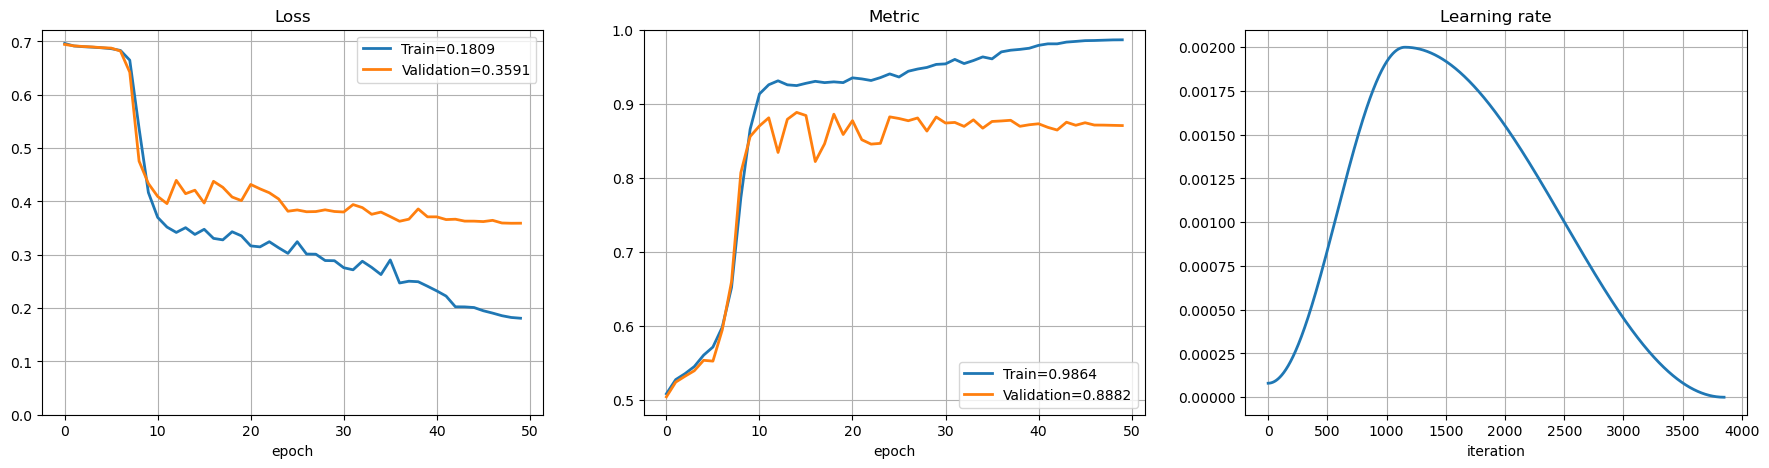

In [21]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()